In [2]:
import pandas as pd
import numpy as np
import joblib
import time
import socket
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

%matplotlib inline

In [3]:
from sklearn.metrics import ndcg_score

def precision(actual, predicted, k):
    act_set = set(actual[:k])
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    
    return result
    
def evaluate_ranking(pred, test, k=5, exponential_scaling=False):    
    ndcg = []
    prec  = []
    for i, pred_row in pred.iterrows():
        test_row = test.loc[i]
        shared_drugs = list(set(pred_row.dropna().index) & set(test_row.dropna().index))
        test_row = test_row[shared_drugs]
        pred_row = pred_row[shared_drugs]
        
        pred_order = pred_row.sort_values().index.tolist()
        test_order = test_row.sort_values().index.tolist()
                        
        if len(shared_drugs) > 1:
            ndcg.append(ndcg_score([test_row.values], [pred_row.values], k=k))
            
        prec.append(precision(test_order, pred_order, k=k))
        
        
    return (np.mean(prec), np.mean(ndcg))

import scipy.stats
from sklearn.metrics import mean_squared_error

def evaluate_mse_pearson(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for i, row in pred.iterrows():
        p = row.dropna()
        g = gt.loc[i].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>5 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        #else: 
        #    pearson_list.append(np.nan)
        #    pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

def evaluate_mse_pearson_per_drug(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for drug in pred.columns:
        p = pred[drug].dropna()
        g = gt[drug].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>2 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        #else: 
        #    pearson_list.append(np.nan)
        #    pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

In [4]:
res_dir = 'predictions/Pancreatic'

import pickle
with open ('data/Pancreatic/splits.pkl', 'rb') as fp:
    splits = pickle.load(fp)
    
full_viability_df = pd.read_csv('/Users/katja/Projects/ProstateCancer/databases/Pancreatic/drug_response/test_viability.csv', index_col = 0)
full_viability_zscore_df = (full_viability_df - full_viability_df.mean()) / full_viability_df.std()

part_viability_df = pd.read_csv('/Users/katja/Projects/ProstateCancer/mlmed_ranking/data/train_test_gdsc_pan/train_test_viab/pan_test.csv', index_col = 0)
part_viability_zscore_df = (part_viability_df - part_viability_df.mean()) / part_viability_df.std()

modes = ['gdsc_pan', 'solo_pan']
viab_conditions = ['AUC', 'AUC_zscore']
ks = [1,3,5,10,15]
    
ranking_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 'k', 
                            'prec', 'ndcg', 'mode'])
mse_pearson_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval', 'mode'])
mse_pearson_eval_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval', 'mode'])
ranking_counter = 0
mp_counter = 0

for mode in modes:
    mode_path = os.path.join(res_dir, mode)
    for cond in viab_conditions:
        cond_path = os.path.join(mode_path, cond)
        if cond == 'AUC': 
            full_test_df = full_viability_df
            part_test_df = part_viability_df
        else: 
            full_test_df = full_viability_zscore_df
            part_test_df = part_viability_zscore_df

        for model in os.listdir(cond_path):
            if model.startswith('.'): continue
            if model in ['multitarget', 'unfiltered']: continue

            model_path = os.path.join(cond_path, model)
            for submodel in os.listdir(model_path):
                if submodel.startswith('.'): continue

                submodel_path = os.path.join(model_path, submodel)        

                if submodel.endswith('zeros') or model == 'mean_baseline': rnaseq = 'no RNAseq'
                elif submodel.endswith('feat_sel'): rnaseq = 'genes selected per drug'
                else: rnaseq = 'paccmann genes'

                print(mode, cond, model, submodel)
                prediction_df = None
                    
                if mode == 'gdsc_pan':
                    for pred_file in os.listdir(submodel_path):
                        if pred_file.startswith('.'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        prediction_df = pd.read_csv(prediction_path, index_col = 0)
                        if model == 'knn':
                            prediction_df = prediction_df.pivot(index = 'cell_line', columns = 'drug', values = 'predictions')
                        else:
                            part_test_df = (part_test_df.T.max() - part_test_df.T).T
                        prediction_df = prediction_df.loc[part_test_df.index][part_test_df.columns]
                        
                        (mse, pearsonr, pval) = evaluate_mse_pearson(prediction_df, part_test_df)
                        mse_pearson_eval.loc[mp_counter] = [model, cond, rnaseq,
                                                                -1, mse, pearsonr, pval, mode]
                        (mse, pearsonr, pval) = evaluate_mse_pearson_per_drug(prediction_df, part_test_df)
                        mse_pearson_eval_per_drug.loc[mp_counter] = [model, cond, rnaseq,
                                                                        -1, mse, pearsonr, pval, mode]
                        mp_counter += 1

                        for k in ks:
                            (prec, ndcg) = evaluate_ranking(prediction_df, part_test_df, k = k)

                            ranking_eval.loc[ranking_counter] = [model, cond, rnaseq,
                                                                -1, k, np.mean(prec), np.mean(ndcg), mode]
                            ranking_counter += 1
                                                        
                elif mode == 'solo_pan':
                    for split_nr, split in enumerate(splits):
                        if model in ['lin_reg_feat_sel', 'mean_baseline']:
                            for pred_file in os.listdir(submodel_path):
                                if pred_file.startswith('.'): continue
                                prediction_path = os.path.join(submodel_path, pred_file)
                                break
                            prediction_df = pd.read_csv(prediction_path, index_col = 0)
                            test_df = full_test_df
                        else:
                            for pred_file in os.listdir(submodel_path):
                                if pred_file.endswith(str(split_nr)+'.csv'): 
                                    prediction_path = os.path.join(submodel_path, pred_file)
                                    break
                            prediction_df = pd.read_csv(prediction_path, index_col = 0)
                            test_df = part_test_df
                            if model == 'knn':
                                prediction_df = prediction_df.pivot(index = 'cell_line', columns = 'drug', values = 'predictions')
                            else:
                                test_df = (test_df.T.max() - test_df.T).T
                            
                        p = prediction_df.loc[split][test_df.columns]
                        g = test_df.loc[split]

                        (mse, pearsonr, pval) = evaluate_mse_pearson(p, g)
                        mse_pearson_eval.loc[mp_counter] = [model, cond, rnaseq,
                                                                    split_nr, mse, pearsonr, pval, mode]
                        (mse, pearsonr, pval) = evaluate_mse_pearson_per_drug(p, g)
                        mse_pearson_eval_per_drug.loc[mp_counter] = [model, cond, rnaseq,
                                                                            split_nr, mse, pearsonr, pval, mode]
                        mp_counter += 1

                        for k in ks:
                            (prec, ndcg) = evaluate_ranking(p, g, k = k)

                            ranking_eval.loc[ranking_counter] = [model, cond, rnaseq,
                                                        split_nr, k, np.mean(prec), np.mean(ndcg), mode]
                            ranking_counter += 1
                        

gdsc_pan AUC knn knn
gdsc_pan AUC knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC paccmann paccmann_mse
gdsc_pan AUC paccmann paccmann_mse_zeros
gdsc_pan AUC paccmann_ndcg paccmann_approx_ndcg_zeros
gdsc_pan AUC paccmann_ndcg paccmann_approx_ndcg


/Users/katja/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC baseline_nn nn_baseline_mse_zeros
gdsc_pan AUC baseline_nn nn_baseline_mse


/Users/katja/miniconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


gdsc_pan AUC_zscore knn knn
gdsc_pan AUC_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC_zscore paccmann paccmann_mse_zscore_zeros
gdsc_pan AUC_zscore paccmann paccmann_mse_zscore
gdsc_pan AUC_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros
gdsc_pan AUC_zscore paccmann_ndcg paccmann_approx_ndcg_zscore


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


gdsc_pan AUC_zscore baseline_nn nn_baseline_mse_zscore
gdsc_pan AUC_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


solo_pan AUC knn knn
solo_pan AUC knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

solo_pan AUC mean_baseline mean_baseline
solo_pan AUC lin_reg_feat_sel lin_reg_feat_sel
solo_pan AUC paccmann paccmann_mse
solo_pan AUC paccmann paccmann_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

solo_pan AUC paccmann_ndcg paccmann_ndcg_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


solo_pan AUC paccmann_ndcg paccmann_ndcg
solo_pan AUC baseline_nn nn_baseline_mse_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

solo_pan AUC baseline_nn nn_baseline_mse
solo_pan AUC_zscore knn knn
solo_pan AUC_zscore knn knn_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

solo_pan AUC_zscore mean_baseline mean_baseline
solo_pan AUC_zscore lin_reg_feat_sel lin_reg_feat_sel
solo_pan AUC_zscore paccmann paccmann_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

solo_pan AUC_zscore paccmann paccmann_mse_zscore
solo_pan AUC_zscore paccmann_ndcg paccmann_ndcg_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

solo_pan AUC_zscore paccmann_ndcg paccmann_ndcg_zscore
solo_pan AUC_zscore baseline_nn nn_baseline_mse_zscore
solo_pan AUC_zscore baseline_nn nn_baseline_mse_zscore_zeros


/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/katja/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in doubl

In [8]:
counter = 0
ranking_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'k', 
                                      'prec', 'prec_std', 'prec_stderror',
                                      'ndcg', 'ndcg_std', 'ndcg_stderror', 'mode'
                                   ])

for (model, drug_response, genes, k, mode), rows in ranking_eval.groupby(['model', 'drug_response', 'genes', 'k', 'mode']):
    ranking_res.loc[counter] = [model, drug_response, genes, k,
                              np.mean(rows.prec), np.std(rows.prec), np.std(rows.prec)/np.sqrt(len(rows.prec)),
                              np.mean(rows.ndcg), np.std(rows.ndcg), np.std(rows.ndcg)/np.sqrt(len(rows.ndcg)),
                              mode
                            ]
    counter+=1
ranking_res.to_csv('tables/results/Pancreatic/pancreatic_ranking_results.csv')
ranking_res

,model,drug_response,genes,k,prec,prec_std,prec_stderror,ndcg,ndcg_std,ndcg_stderror,mode
0,baseline_nn,AUC,no RNAseq,1,0.023256,0.000000,0.000000,0.398615,0.000000,0.000000,gdsc_pan
1,baseline_nn,AUC,no RNAseq,1,0.375000,0.234787,0.074246,1.000000,0.000000,0.000000,solo_pan
2,baseline_nn,AUC,no RNAseq,3,0.558140,0.000000,0.000000,0.776661,0.000000,0.000000,gdsc_pan
3,baseline_nn,AUC,no RNAseq,3,0.640000,0.072725,0.022998,0.987525,0.010803,0.003416,solo_pan
4,baseline_nn,AUC,no RNAseq,5,0.613953,0.000000,0.000000,0.794724,0.000000,0.000000,gdsc_pan
...,...,...,...,...,...,...,...,...,...,...,...
175,paccmann_ndcg,AUC_zscore,paccmann genes,5,0.290000,0.064187,0.020298,0.497377,0.058069,0.018363,solo_pan
176,paccmann_ndcg,AUC_zscore,paccmann genes,10,0.727907,0.000000,0.000000,0.709464,0.000000,0.000000,gdsc_pan
177,paccmann_ndcg,AUC_zscore,paccmann genes,10,0.681500,0.025105,0.007939,0.618875,0.051938,0.016424,solo_pan
178,paccmann_ndcg,AUC_zscore,paccmann genes,15,0.931783,0.000000,0.000000,0.825719,0.000000,0.000000,gdsc_pan


In [5]:
counter = 0
mse_pearson_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean', 'mode'])

for (model, drug_response, genes, mode), rows in mse_pearson_eval.groupby(['model', 'drug_response', 'genes', 'mode']):
    mse_pearson_res.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval), mode
                            ]
    counter+=1
mse_pearson_res.to_csv('tables/results/Pancreatic/pancreatic_mse_pearson_per_organoid.csv')
mse_pearson_res

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean,mode
0,baseline_nn,AUC,no RNAseq,0.015446,0.000000,0.000000,0.656021,0.000000,0.000000,1.615466e-02,gdsc_pan
1,baseline_nn,AUC,no RNAseq,0.003730,0.001038,0.000328,0.945986,0.016261,0.005142,4.607942e-06,solo_pan
2,baseline_nn,AUC,paccmann genes,0.113172,0.000000,0.000000,-0.279848,0.000000,0.000000,3.780110e-01,gdsc_pan
3,baseline_nn,AUC,paccmann genes,0.051681,0.024456,0.007734,0.877262,0.032938,0.010416,2.892992e-04,solo_pan
4,baseline_nn,AUC_zscore,no RNAseq,1.194463,0.000000,0.000000,0.004488,0.000000,0.000000,5.222406e-01,gdsc_pan
5,baseline_nn,AUC_zscore,no RNAseq,0.848178,0.290413,0.091837,-0.401633,0.136558,0.043183,2.202432e-01,solo_pan
6,baseline_nn,AUC_zscore,paccmann genes,1.028331,0.000000,0.000000,-0.051317,0.000000,0.000000,4.789065e-01,gdsc_pan
7,baseline_nn,AUC_zscore,paccmann genes,0.830402,0.300944,0.095167,-0.063091,0.198175,0.062668,3.932897e-01,solo_pan
8,knn,AUC,no RNAseq,0.046631,0.000000,0.000000,0.616476,0.000000,0.000000,2.556371e-02,gdsc_pan
9,knn,AUC,no RNAseq,0.008002,0.002300,0.000727,0.898957,0.019996,0.006323,7.273960e-05,solo_pan


In [6]:
def extract_metrics(mse_pearson, models):
    pearson = []
    pearson_err = []
    mse = []
    mse_err = []
    for model in models:
        row = mse_pearson[mse_pearson.model == model]
        if len(row) == 0:
            pearson.append(0)
            pearson_err.append(0)
            mse.append(0)
            mse_err.append(0)
        else:
            pearson.append(row.pearson.values[0])
            pearson_err.append(row.pearson_stderror.values[0])
            mse.append(row.mse.values[0])
            mse_err.append(row.mse_stderror.values[0])
    return (pearson, pearson_err, mse, mse_err)

/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_55035/1481027994.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs[1].grid(b=True, axis='y')
/var/folders/rp/n5c8n15j53ndhqzy0t3qglcw0000gq/T/ipykernel_55035/1481027994.py:58: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axs[0].grid(b=True, axis='y')


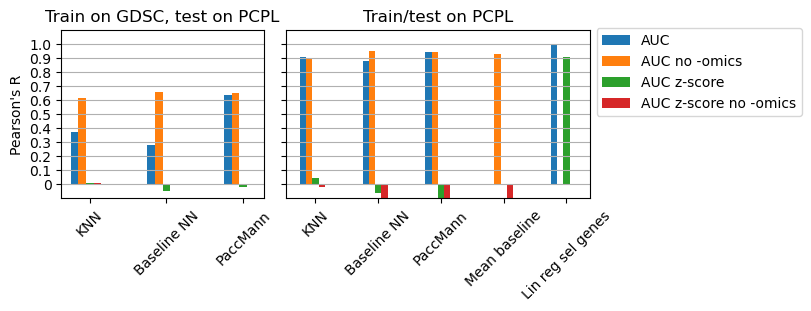

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3), constrained_layout=True, sharey = True,
                        gridspec_kw={'width_ratios':[1, 1.5]})
axs = axs.ravel()

auc_rows = mse_pearson_res[(mse_pearson_res.drug_response == 'AUC')&(mse_pearson_res['mode'] == 'solo_pan')]
auc_zscore_rows = mse_pearson_res[(mse_pearson_res.drug_response == 'AUC_zscore')&(mse_pearson_res['mode'] == 'solo_pan')]

X = ['knn', 'baseline_nn', 'paccmann', 'mean_baseline', 'lin_reg_feat_sel']
X_lab = ['KNN', 'Baseline NN', 'PaccMann', 'Mean baseline', 'Lin reg sel genes']
X_axis = np.arange(len(X))

(AUC_pearson, AUC_pearson_err, AUC_mse, AUC_mse_err) = extract_metrics(auc_rows[(auc_rows.genes != 'no RNAseq')], X)
(AUCzero_pearson, AUCzero_pearson_err, AUCzero_mse, AUCzero_mse_err) = extract_metrics(auc_rows[(auc_rows.genes == 'no RNAseq')], X)

(AUCz_pearson, AUCz_pearson_err, AUCz_mse, AUCz_mse_err) = extract_metrics(auc_zscore_rows[(auc_zscore_rows.genes != 'no RNAseq')], X)
(AUCzzero_pearson, AUCzzero_pearson_err, AUCzzero_mse, AUCzzero_mse_err) = extract_metrics(auc_zscore_rows[(auc_zscore_rows.genes == 'no RNAseq')], X)

axs[1].bar(X_axis - 0.2, AUC_pearson, 0.1, label = 'AUC')
axs[1].bar(X_axis - 0.1, AUCzero_pearson, 0.1, label = 'AUC no -omics')
axs[1].bar(X_axis + 0, AUCz_pearson, 0.1, label = 'AUC z-score')
axs[1].bar(X_axis + 0.1, AUCzzero_pearson, 0.1, label = 'AUC z-score no -omics')

axs[1].set_title('Train/test on PCPL')
axs[1].grid(axis='y')
axs[1].set_ylim(-0.1, 1.1)
#axs[0].set_xlim(0, 2)

Y = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
axs[1].set_yticks(Y, Y)

axs[1].set_xticks(X_axis, X_lab, rotation = 45)
axs[1].grid(b=True, axis='y')
axs[1].legend(bbox_to_anchor=(1, 1.05))

###########

models = ['knn', 'baseline_nn', 'paccmann']

auc_rows = mse_pearson_res[(mse_pearson_res.drug_response == 'AUC')&(mse_pearson_res['mode'] == 'gdsc_pan')].set_index('model').loc[models]
auc_zscore_rows = mse_pearson_res[(mse_pearson_res.drug_response == 'AUC_zscore')&(mse_pearson_res['mode'] == 'gdsc_pan')].set_index('model').loc[models]

X = models
X_axis = np.arange(len(X))
X_lab = ['KNN', 'Baseline NN', 'PaccMann']

axs[0].bar(X_axis - 0.2, auc_rows[auc_rows.genes != 'no RNAseq'].pearson.values, 0.1, label = 'AUC')
axs[0].bar(X_axis - 0.1, auc_rows[auc_rows.genes == 'no RNAseq'].pearson.values, 0.1, label = 'AUC no -omics')
axs[0].bar(X_axis - 0, auc_zscore_rows[auc_zscore_rows.genes != 'no RNAseq'].pearson.values, 0.1, label = 'AUC zscore')
axs[0].bar(X_axis + 0.1, auc_zscore_rows[auc_zscore_rows.genes == 'no RNAseq'].pearson.values, 0.1, label = 'AUC zscore no -omics')


axs[0].set_title('Train on GDSC, test on PCPL')
axs[0].grid(axis='y')
#axs[0].set_ylim(-0.1, 1.1)
#axs[0].set_xlim(0, 2)

axs[0].set_xticks(X_axis, X_lab, rotation = 45)
axs[0].grid(b=True, axis='y')
axs[0].set_ylabel("Pearson's R")
#axs[0].legend(bbox_to_anchor=(1, 1.05))

plt.savefig('figures/results/Pancreatic/pancreatic_pearson.png', facecolor = 'white', transparent = False, dpi=500)    

In [7]:
counter = 0
mse_pearson_res_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean', 'mode'])

for (model, drug_response, genes, mode), rows in mse_pearson_eval_per_drug.groupby(['model', 'drug_response', 'genes', 'mode']):
    mse_pearson_res_per_drug.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), 
                              np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval), mode
                            ]
    counter+=1
mse_pearson_res_per_drug.to_csv('tables/results/Pancreatic/pancreatic_mse_pearson_per_drug.csv')
mse_pearson_res_per_drug

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean,mode
0,baseline_nn,AUC,no RNAseq,0.015441,0.000000,0.000000,NaN,NaN,NaN,NaN,gdsc_pan
1,baseline_nn,AUC,no RNAseq,0.003732,0.001038,0.000328,NaN,NaN,NaN,NaN,solo_pan
2,baseline_nn,AUC,paccmann genes,0.113185,0.000000,0.000000,NaN,NaN,NaN,NaN,gdsc_pan
3,baseline_nn,AUC,paccmann genes,0.051702,0.024452,0.007732,-0.007594,0.224648,0.071040,0.448061,solo_pan
4,baseline_nn,AUC_zscore,no RNAseq,1.194605,0.000000,0.000000,NaN,NaN,NaN,NaN,gdsc_pan
5,baseline_nn,AUC_zscore,no RNAseq,0.848477,0.290522,0.091871,NaN,NaN,NaN,NaN,solo_pan
6,baseline_nn,AUC_zscore,paccmann genes,1.029782,0.000000,0.000000,0.079768,0.000000,0.000000,0.389146,gdsc_pan
7,baseline_nn,AUC_zscore,paccmann genes,0.830716,0.301056,0.095202,0.154666,0.231827,0.073310,0.486705,solo_pan
8,knn,AUC,no RNAseq,0.046558,0.000000,0.000000,NaN,NaN,NaN,NaN,gdsc_pan
9,knn,AUC,no RNAseq,0.007988,0.002287,0.000723,NaN,NaN,NaN,NaN,solo_pan


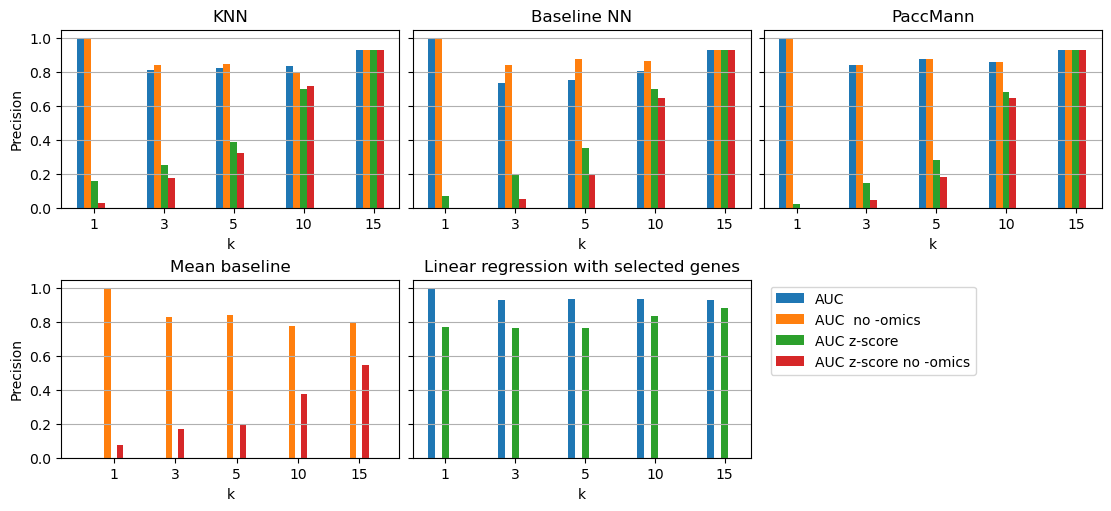

In [55]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11,5), constrained_layout=True, 
                        sharey=True)
axs = axs.ravel()

X = ks
X_axis = np.arange(len(X))
X_lab = ['KNN', 'Baseline NN', 'PaccMann']

for i, model in enumerate(['knn', 'baseline_nn', 'paccmann']):
    model_ranking = ranking_res[(ranking_res.model == model) & (ranking_res['mode'] == 'solo_pan')]
    if len(model_ranking) == 0: continue
    
    axs[i].bar(X_axis - 0.2, model_ranking[(model_ranking.drug_response == 'AUC')&
                                           (model_ranking.genes != 'no RNAseq')].prec.values, 0.1, 
               label = 'AUC')
    axs[i].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'AUC')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'AUC no -omics')
    axs[i].bar(X_axis - 0, model_ranking[(model_ranking.drug_response == 'AUC_zscore')&
                                           (model_ranking.genes != 'no RNAseq')].prec.values, 0.1, label = 'AUC zscore')
    axs[i].bar(X_axis + 0.1, model_ranking[(model_ranking.drug_response == 'AUC_zscore')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'AUC zscore no -omics')
    axs[i].set_title(X_lab[i])
    axs[i].set_xticks(X_axis, X)
    if i == 0: axs[i].set_ylabel("Precision")
    axs[i].set_xlabel("k")
    axs[i].grid(axis='y')
    
    #axs[i].legend(loc = 'upper right')



####

model = 'mean_baseline'
model_ranking = ranking_res[(ranking_res.model == model) & (ranking_res['mode'] == 'solo_pan')]

axs[3].bar(X_axis - 0.2, [0], label = 'AUC')
axs[3].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'AUC')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, 
           label = 'AUC no -omics ')
axs[3].bar(X_axis - 0, [0], label = 'AUC z-score')
axs[3].bar(X_axis + 0.1, model_ranking[(model_ranking.drug_response == 'AUC_zscore')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, 
           label = 'AUC z=score no -omics ')

axs[3].set_title('Mean baseline')
axs[3].set_xticks(X_axis, X)
axs[3].set_ylabel("Precision")
axs[3].set_xlabel("k")
axs[3].grid(axis='y')


####

model = 'lin_reg_feat_sel'
model_ranking = ranking_res[(ranking_res.model == model) & (ranking_res['mode'] == 'solo_pan')]

axs[4].bar(X_axis - 0.2, model_ranking[(model_ranking.drug_response == 'AUC')&
                                           (model_ranking.genes != 'no RNAseq')].prec.values, 0.1, 
           label = 'AUC')
axs[4].bar(X_axis - 0.1, [0], 0.1, label = 'AUC  no -omics')
axs[4].bar(X_axis + 0, model_ranking[(model_ranking.drug_response == 'AUC_zscore')&
                                           (model_ranking.genes != 'no RNAseq')].prec.values, 0.1, 
           label = 'AUC z-score')
axs[4].bar(X_axis + 0.1, [0], 0.1, label = 'AUC z-score no -omics')


axs[4].set_title('Linear regression with selected genes')
axs[4].set_xticks(X_axis, X)
#axs[4].set_ylabel("Precision")
axs[4].set_xlabel("k")
axs[4].grid(axis='y')

handles, labels = axs[4].get_legend_handles_labels()
axs[5].legend(handles, labels, loc = "upper left")
axs[5].axis('off')

plt.savefig('figures/results/Pancreatic/Pancreatic_models_ranking_solo.png', facecolor = 'white', transparent = False, dpi=500)

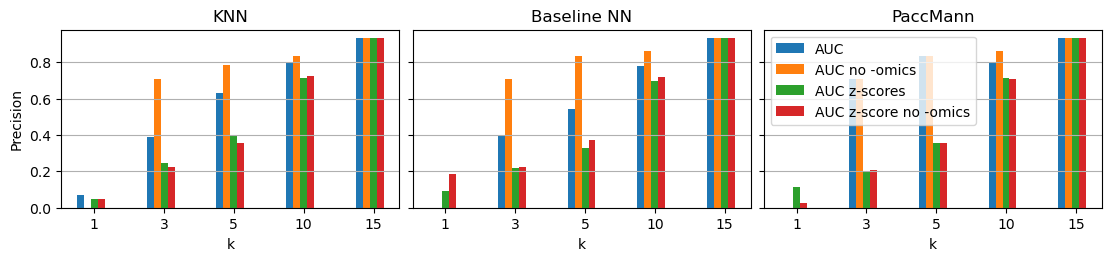

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11,2.5), constrained_layout=True, 
                        sharey=True, sharex=True)
axs = axs.ravel()

X = ks
X_axis = np.arange(len(X))
X_lab = ['KNN', 'Baseline NN', 'PaccMann']

for i, model in enumerate(['knn', 'baseline_nn', 'paccmann']):
    model_ranking = ranking_res[(ranking_res.model == model) & (ranking_res['mode'] == 'gdsc_pan')]
    
    
    axs[i].bar(X_axis - 0.2, model_ranking[(model_ranking.drug_response == 'AUC')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, 
               label = 'AUC')
    axs[i].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'AUC')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, 
               label = 'AUC no -omics')
    axs[i].bar(X_axis + 0, model_ranking[(model_ranking.drug_response == 'AUC_zscore')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, 
               label = 'AUC z-scores')
    axs[i].bar(X_axis + 0.1, model_ranking[(model_ranking.drug_response == 'AUC_zscore')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, 
               label = 'AUC z-score no -omics')
    
    axs[i].set_title(X_lab[i])
    axs[i].set_xticks(X_axis, X)
    if i in [0]: axs[i].set_ylabel("Precision")
    axs[i].set_xlabel("k")
    axs[i].grid(axis='y')
    
    if i == 2:
        axs[i].legend(loc = 'upper left')


plt.savefig('figures/results/Pancreatic/pancreatic_models_ranking_with_GDSC.png', facecolor = 'white', transparent = False, dpi=500)